# An investigation into customer demographics

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
#Importing libraries
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import load_digits
from sklearn.tree import plot_tree

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

%matplotlib inline

<ipython-input-2-95a2d9ac8b52>:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


We are given a dataset of 80,000 customer purchases in an electronic store, Blackwell electronics. This dataset contains 5 variables, whether the purchase was online or in-store, the age of the customer, how many items were purchased, the amount spent and the region the purchase was made.

Some important mapping information:

Column 'in-store': 
0 = purchased online
1 = purchesd in store

Column 'region':
1 = North
2 = South
3 = East
4 = West

In [3]:
#importing data
data = pd.read_csv("C:\\Ubiqum\Python\Introduction\Demographic_Data.csv")
#Lets see our data
data.head()

,in-store,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4
3,1,46,3,715.25,3
4,1,33,4,1937.50,1


# EDA (Exploratory Data Analysis)

In [4]:
print("No null values in our data:")
data.isnull().sum()

No null values in our data:


in-store    0
age         0
items       0
amount      0
region      0
dtype: int64

We will drop all duplicates in our data, it is unlikely a customer makes the exact same purchase more than once.

In [5]:
#filter dupes
dupes = data[data.duplicated() == True]

#remove dupes
data = data.drop_duplicates()

print("There are " +str(len(dupes))+ " duplicates which will be removed from our dataset:")
print(dupes)

There are 21 duplicates which will be removed from our dataset:
       in-store  age  items   amount  region
17858         0   76      6   283.61       2
26112         0   67      4   320.41       2
29343         1   23      2  1019.50       4
33834         1   38      3  1993.80       1
34214         1   31      5  1488.10       4
34706         0   39      5  1268.00       4
35971         0   38      7   391.51       2
43958         1   22      1  1303.20       4
44308         1   26      5  1495.70       4
45164         0   79      6   342.28       2
47414         0   27      6  1555.10       4
51600         0   56      2  1941.70       4
52013         1   50      5  1889.40       1
53652         0   29      2   144.43       2
58454         0   76      1   259.44       2
59539         1   49      2  1162.00       4
59859         0   30      7  2535.10       4
61439         1   32      4  1106.10       4
63970         1   42      5  1731.10       4
75506         0   44      2  1756.70

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79979 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   in-store  79979 non-null  int64  
 1   age       79979 non-null  int64  
 2   items     79979 non-null  int64  
 3   amount    79979 non-null  float64
 4   region    79979 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.7 MB


In [7]:
#Creating a regional dictionary for later use
region_dict = {1: 'North',
               2: 'South',
               3: 'East',
               4: 'West'}
online_dict = {0: 'Online',
              1:'In-Store'}


In [8]:
#Looking into the mean of the data based on region
avg_data_v1 = data.groupby('region').mean()
avg_data_v1.reset_index(inplace = True)
print("The mean data for all our features:")
print(avg_data_v1)

The mean data for all our features:
   region  in-store        age     items       amount
0       1  1.000000  43.704132  4.510283   744.990939
1       2  0.000000  56.609083  4.512804   252.097741
2       3  0.611056  45.646944  4.494000   917.969637
3       4  0.500000  38.752424  4.503771  1283.938357


The region 1 'in-store' mean is 1, and region 2 is 0 meaning all purchases in region 1 are done in store and all in region 2 are online.
The average age varies between regions, with region 2 (South) having the highest average age by 10 years, and the West having the youngest average age.  
The number of items purchased per transaction is fairly constant across all regions at around 4.5 items, however, the amount spent varies greatly. 

Text(0.5, 1.0, 'Correlation matrix of all variables')

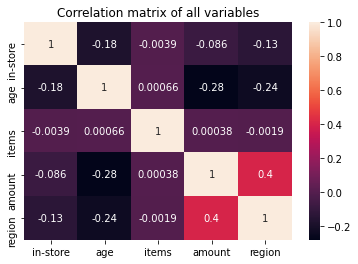

In [9]:
corr_heatmap=sns.heatmap(data.corr(),annot=True)
corr_heatmap.set_title('Correlation matrix of all variables')

The strongest correlation is between region and amount at 0.4 implying the amount spent goes up with the region. We will look into this further.

## Age

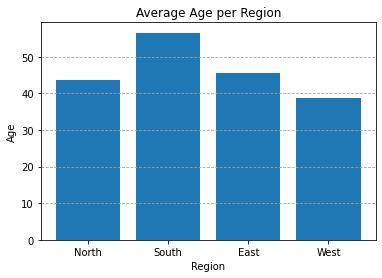

In [10]:
#Plotting a bar chart to show the average age in each region
plt.bar(x = avg_data_v1['region'], height = avg_data_v1['age'])
plt.title('Average Age per Region')
plt.ylabel('Age')
plt.xlabel('Region')
plt.grid(color = '#95a5a6', linestyle='--', axis = 'y')
plt.xticks([1,2,3,4],['North', 'South', 'East', 'West'])
plt.show()

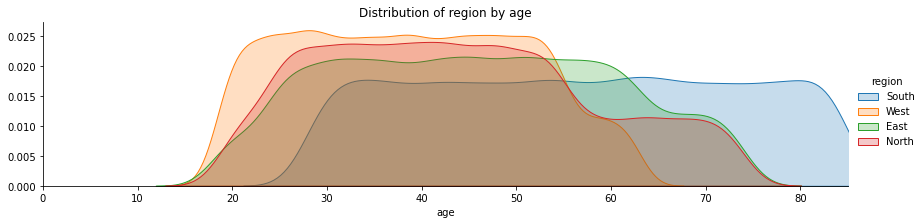

In [22]:
fig = sns.FacetGrid(data.replace({'region': region_dict}), hue='region', aspect=4)
fig.map(sns.kdeplot, 'age', shade=True)
fig.set(xlim=(0,data['age'].max()))
fig.set(title='Distribution of region by age')
fig.add_legend()

We can see large variations in the age distributions across every region. The South has an even distribution starting from ~30 to ~80 years old. The West has the largest population which is a younger demographic, evenly distributed from ~18 to ~55 years old with a much smaller population older than that. The East has more of a normal distribution, with smaller numbers at very young and very old. Finally, the North has a normal lookign distribution up until ~55 years old where it drops off.

Text(0.5, 1.0, 'Age distribution across regions')

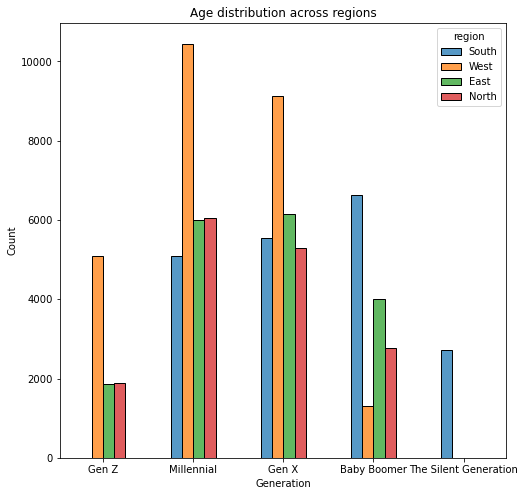

In [12]:
#Creating a Generation column to convert age to generations
data['Generation'] = pd.cut(x = data['age'], bins = [17,26,42,58,77,86], labels = ['Gen Z', 'Millennial', 'Gen X','Baby Boomer','The Silent Generation'])

#Splitting the data to get regional data
region_1_data =  data[data['region'] == 1]
region_2_data =  data[data['region'] == 2]
region_3_data =  data[data['region'] == 3]
region_4_data =  data[data['region'] == 4]

#Plotting a graph with all regions age distributions
plt.figure(figsize=(8,8))
sns.histplot(shrink=0.5, x="Generation", hue="region", data=data.replace({'region': region_dict}), stat="count", multiple="dodge")
plt.title('Age distribution across regions')

The South has a much older generation than others, and the West is a lot younger.

Text(0.5, 1.0, 'How age varies across regions')

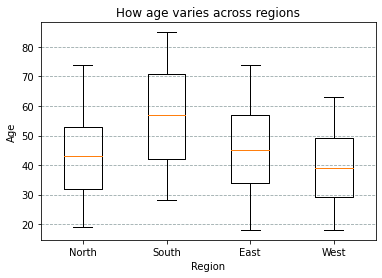

In [13]:
combo_items =[region_1_data['age'],region_2_data['age'],region_3_data['age'],region_4_data['age']]
#Plotting box plot
plt.boxplot(combo_items,0,'gD')
plt.xlabel('Region')
plt.ylabel('Age')
plt.xticks(ticks=[1,2,3,4],labels=['North','South','East','West'])
plt.grid(color = '#95a5a6', linestyle='--', axis = 'y')
plt.title('How age varies across regions')

Finally, the above boxplot shows the spread of ages we have per region, with the orange line the mean age, and the other four horizontal lines (going low to high) representing the lowest age, the lower quartile age, upper quartile and the final line the eldest customer per region.

## Amount

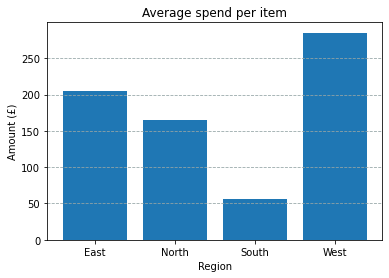

In [14]:
#Function to find the average amount
def weighted_avg(dataframe, item, amounts):
    item_numb = dataframe[item]
    amount_numb = dataframe[amounts]
    return amount_numb.sum() /item_numb.sum()

wgt_avg_data = data.replace({'region': region_dict}).groupby('region').apply(weighted_avg,'items','amount')
#Turn series into a Data Frame
wgt_avg_data_df = wgt_avg_data.to_frame()
#rearrange the index
wgt_avg_data_df.reset_index(inplace = True)
#Rename columns
wgt_avg_data_df.columns = ['Region','Average spend per Transaction per item']
#plotting the bar chart
plt.bar( x= wgt_avg_data_df['Region'],height = wgt_avg_data_df['Average spend per Transaction per item'])
#adding titles, labels & grid lines
plt.title('Average spend per item')
plt.ylabel('Amount (£)')
plt.xlabel('Region')
plt.grid(color = '#95a5a6', linestyle='--', axis = 'y')

The average spend per item in the West region is drastcially higher than all others. We can look at how this average price per item varies over instore and online purchases across the regions.

In [15]:
online_df = data[data['in-store']==0]
instore_df = data[data['in-store']==1]

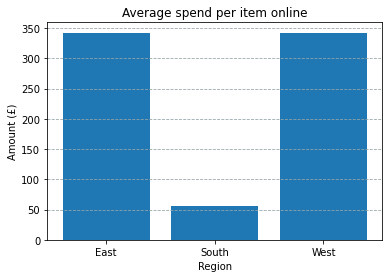

In [16]:
wgt_avg_data_online = online_df.replace({'region': region_dict}).groupby('region').apply(weighted_avg,'items','amount')
#Turn series into a Data Frame
wgt_avg_data_df_online = wgt_avg_data_online.to_frame()
#rearrange the index
wgt_avg_data_df_online.reset_index(inplace = True)
#Rename columns
wgt_avg_data_df_online.columns = ['Region','Average spend per Transaction per item']
#plotting the bar chart
plt.bar( x= wgt_avg_data_df_online['Region'],height = wgt_avg_data_df_online['Average spend per Transaction per item'])
#adding titles, labels & grid lines
plt.title('Average spend per item online')
plt.ylabel('Amount (£)')
plt.xlabel('Region')
plt.grid(color = '#95a5a6', linestyle='--', axis = 'y')

North has no online purchases, the average price per item in the South is very cheap and the East and West look to have very similar average prices (this data is not real).

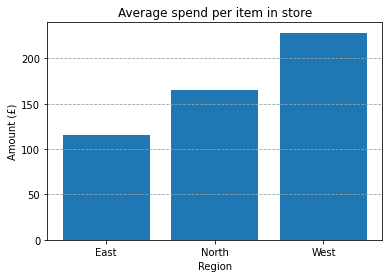

In [17]:
wgt_avg_data_instore = instore_df.replace({'region': region_dict}).groupby('region').apply(weighted_avg,'items','amount')
#Turn series into a Data Frame
wgt_avg_data_df_instore = wgt_avg_data_instore.to_frame()
#rearrange the index
wgt_avg_data_df_instore.reset_index(inplace = True)
#Rename columns
wgt_avg_data_df_instore.columns = ['Region','Average spend per Transaction per item']
#plotting the bar chart
plt.bar( x= wgt_avg_data_df_instore['Region'],height = wgt_avg_data_df_instore['Average spend per Transaction per item'])
#adding titles, labels & grid lines
plt.title('Average spend per item in store')
plt.ylabel('Amount (£)')
plt.xlabel('Region')
plt.grid(color = '#95a5a6', linestyle='--', axis = 'y')

In-store items are cheapest in the East, gradually getting more expensive as we move to North and the West which is the most expensive. There were no in store purchases in the South.

Text(0.5, 1.0, 'Percentage of total revenue from each region')

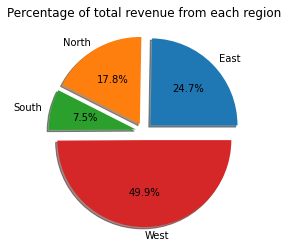

In [18]:
#Finding the totals of each region 
total_data_region = data.replace({'region': region_dict}).groupby('region').sum().reset_index()
#Plotting the pie chart
plt.pie(x = total_data_region['amount'], labels = total_data_region['region'] , explode = [0.1,0.1,0.1,0.1], shadow = True, autopct='%1.1f%%')
plt.title('Percentage of total revenue from each region')

The West generates almost half of all sales revenue, with the East responsible for a quarter.

C:\Users\domsi\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


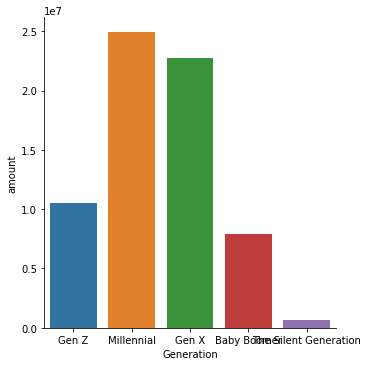

In [24]:
generation_spend = pd.DataFrame(data.groupby(['Generation'])['amount'].sum())
generation_spend.reset_index(inplace=True)

sns.factorplot(data=generation_spend,x='Generation',y='amount',kind='bar')

[Text(0, 0, '18'),
 Text(1, 0, '19'),
 Text(2, 0, '20'),
 Text(3, 0, '21'),
 Text(4, 0, '22'),
 Text(5, 0, '23'),
 Text(6, 0, '24'),
 Text(7, 0, '25'),
 Text(8, 0, '26'),
 Text(9, 0, '27'),
 Text(10, 0, '28'),
 Text(11, 0, '29'),
 Text(12, 0, '30'),
 Text(13, 0, '31'),
 Text(14, 0, '32'),
 Text(15, 0, '33'),
 Text(16, 0, '34'),
 Text(17, 0, '35'),
 Text(18, 0, '36'),
 Text(19, 0, '37'),
 Text(20, 0, '38'),
 Text(21, 0, '39'),
 Text(22, 0, '40'),
 Text(23, 0, '41'),
 Text(24, 0, '42'),
 Text(25, 0, '43'),
 Text(26, 0, '44'),
 Text(27, 0, '45'),
 Text(28, 0, '46'),
 Text(29, 0, '47'),
 Text(30, 0, '48'),
 Text(31, 0, '49'),
 Text(32, 0, '50'),
 Text(33, 0, '51'),
 Text(34, 0, '52'),
 Text(35, 0, '53'),
 Text(36, 0, '54'),
 Text(37, 0, '55'),
 Text(38, 0, '56'),
 Text(39, 0, '57'),
 Text(40, 0, '58'),
 Text(41, 0, '59'),
 Text(42, 0, '60'),
 Text(43, 0, '61'),
 Text(44, 0, '62'),
 Text(45, 0, '63'),
 Text(46, 0, '64'),
 Text(47, 0, '65'),
 Text(48, 0, '66'),
 Text(49, 0, '67'),
 Text(50, 

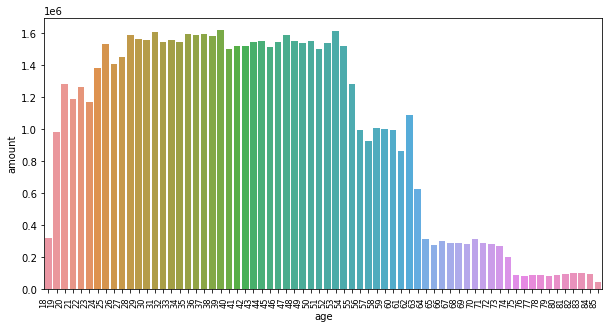

In [25]:
plt.figure(figsize=(10,5))
age_spend = pd.DataFrame(data.groupby(['age'])['amount'].sum())
age_spend.reset_index(inplace=True)
age_spend_chart= sns.barplot(data=age_spend,x='age',y='amount')
age_spend_chart.set_xticklabels(
    age_spend_chart.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'    
)


From the above we can get a better assesment of where the majority of income is coming from, ~25 - ~55 is the bulk of revenue.

## Items

In [26]:
data.replace({'region': region_dict}).groupby('region')['items'].count()

region
East     18000
North    15997
South    19994
West     25988
Name: items, dtype: int64

The West has a much higher item count than the other regions (despite the mean item per transaction being the same across all regions. The below chart shows the number of transcations being much higher, evening out the means across the regions.

C:\Users\domsi\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


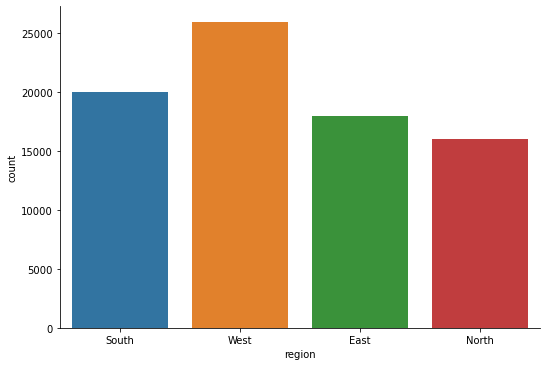

In [27]:
sns.factorplot(data=data.replace({'region': region_dict}),x='region', kind='count', aspect=1.5)

From the below, there doesn't seem to be any relationship between the number of items purchaes and the amount spent. We can check this with a correlation matrix.

In [28]:
corr_mat = data[['items','amount']].corr() # [['items','amount']]
print(corr_mat)

           items    amount
items   1.000000  0.000384
amount  0.000384  1.000000


As expected, there is no correlation between the number of items purchased and the amount spent which could imply different regions are selling completely different items.

In [29]:
item_1 = data[data['items'] == 1]
item_1.describe()

,in-store,age,items,amount,region
count,5699.000000,5699.000000,5699.0,5699.000000,5699.000000
mean,0.501667,45.968416,1.0,825.401751,2.690647
std,0.500041,15.670116,0.0,714.696664,1.125006
min,0.000000,18.000000,1.0,5.304300,1.000000
25%,0.000000,34.000000,1.0,284.220000,2.000000
50%,1.000000,44.000000,1.0,571.980000,3.000000
75%,1.000000,57.000000,1.0,1199.350000,4.000000
max,1.000000,85.000000,1.0,2998.600000,4.000000


## Online/In store purchasing

In [30]:
# Creating more easily read dataset, replacing numbers with names 
data_2 = data.replace({'in-store': online_dict,
                      'region': region_dict})

### Where do different generations purchase their transactions?

<AxesSubplot:xlabel='Generation', ylabel='Count'>

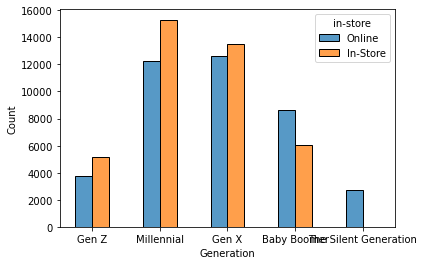

In [31]:
sns.histplot(shrink=0.5, x="Generation", hue="in-store", data=data.replace({'region': region_dict,'in-store':online_dict}), stat="count", multiple="dodge")

Text(0.5, 1.0, 'Purchasing behaviour across generations of customers')

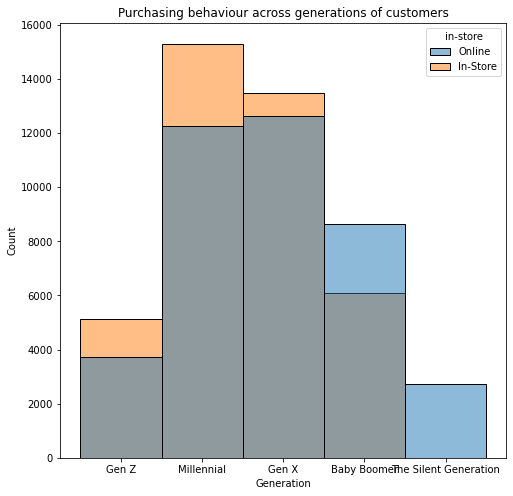

In [32]:
#The same graph as above overlapping
plt.figure(figsize=(8,8))
sns.histplot(data=data_2, binwidth=0.5, x="Generation", hue="in-store", stat="count", multiple="layer")
plt.title('Purchasing behaviour across generations of customers')

From the we see that in general, the older customers (Baby Boomers and the Silent Generation) prefer to purchase online, whereas the younger generations (Gen Z, Millenial, and Gen X) prefer to buy in-store.
This could be for many reasons, including delivery for online shopping being an easier option for older customers, the local store location being difficult to access for elderly people.

array([[<AxesSubplot:ylabel='Gen Z'>, <AxesSubplot:ylabel='Millennial'>],
       [<AxesSubplot:ylabel='Gen X'>, <AxesSubplot:ylabel='Baby Boomer'>],
       [<AxesSubplot:ylabel='The Silent Generation'>, <AxesSubplot:>]],
      dtype=object)

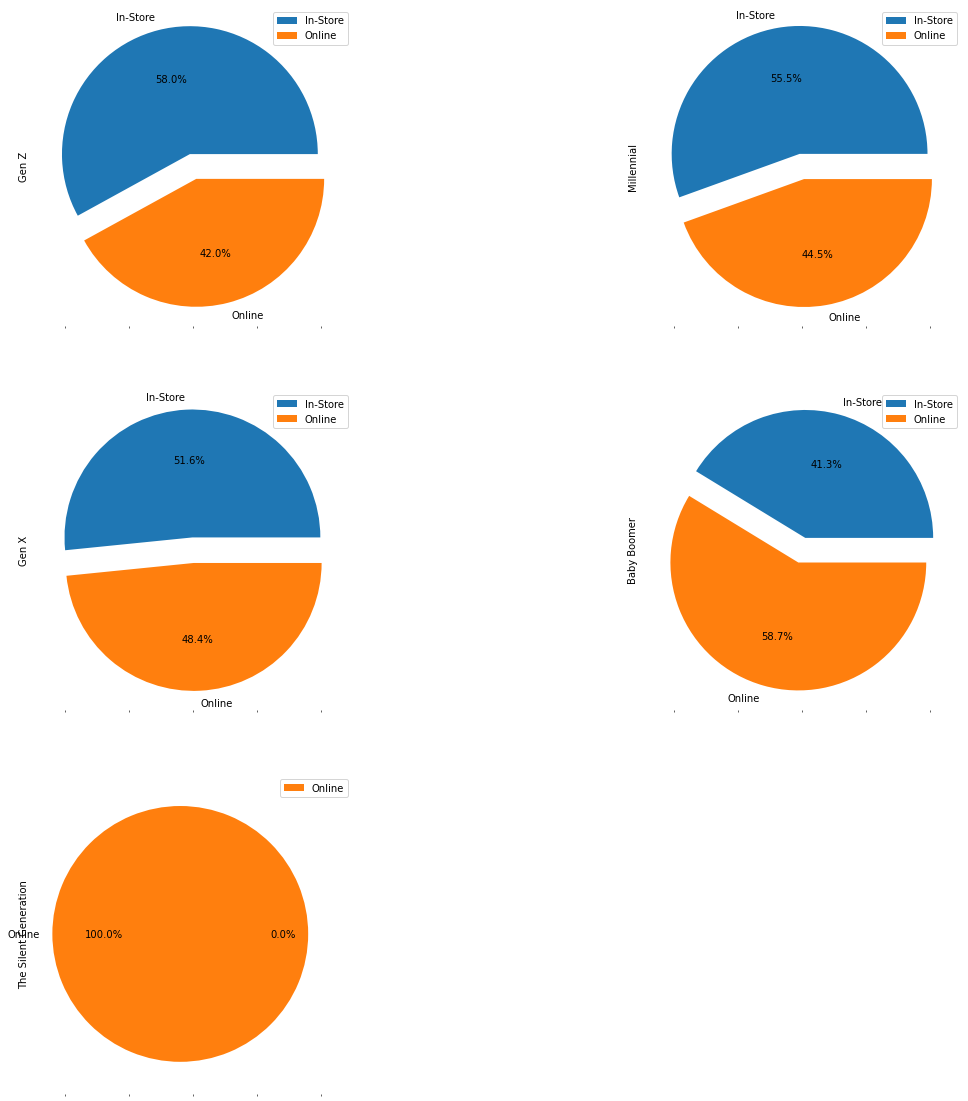

In [33]:
data_count_gen = data_2.groupby(['in-store', 'Generation']).size().unstack()
data_count_gen.plot.pie(subplots=True, figsize=(20, 20),layout=(3,2),explode = [0.1,0.1],autopct='%1.1f%%')

Every single purchase made by a customer from the Silent Generation was made online, and Baby Boomers also buy 17% more products online than in-store.

### Do other factors correlate to an online or in-store transaction?

#### Number of items

<AxesSubplot:xlabel='items', ylabel='Count'>

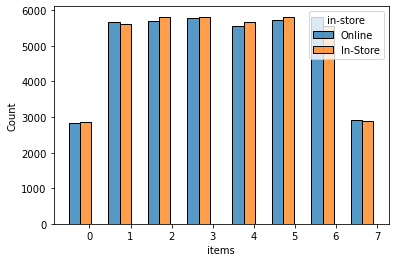

In [34]:
data_count_items = data_2.groupby(['in-store', 'items']).size().unstack() 
sns.histplot(shrink=4, x="items", hue="in-store", data=data_2, stat="count", multiple="dodge")

We can see from the above graph that the number of items bought per transaction does not change if the transaction was done in-store or online, hence there is nothing further to investigate between this relationship.

#### Regions

<AxesSubplot:xlabel='region', ylabel='Count'>

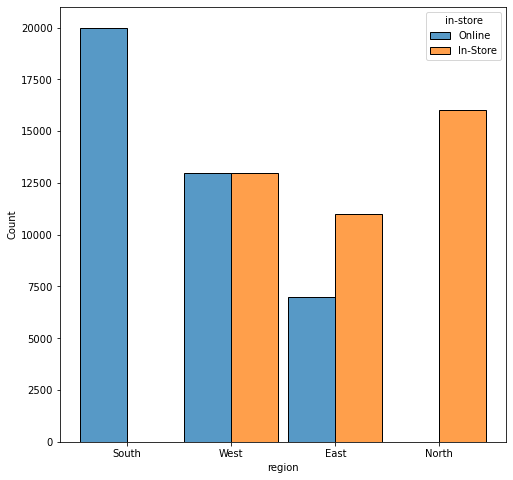

In [35]:
plt.figure(figsize=(8,8))
sns.histplot(shrink = .9, x="region", hue="in-store", data=data_2, stat="count", multiple="dodge")

In [36]:
data_count_region = data_2.groupby(['in-store', 'region']).size().unstack()
data_count_region

region,East,North,South,West
in-store,,,,
In-Store,10999.0,15997.0,NaN,12994.0
Online,7001.0,NaN,19994.0,12994.0


From the above chart and table we can see clear evidence that customers in the North have only bought in-store, and customers in the South have only bought online. This may be due to the age demographics of the regions, with region 2 (the South) having the only population of the Silent Generation who only buy online. Another factors to consider is the store locations (are they easily accessible?).

#### Amount

Text(0.5, 1.0, 'A chart showing how the number of transactions changes per amount spent')

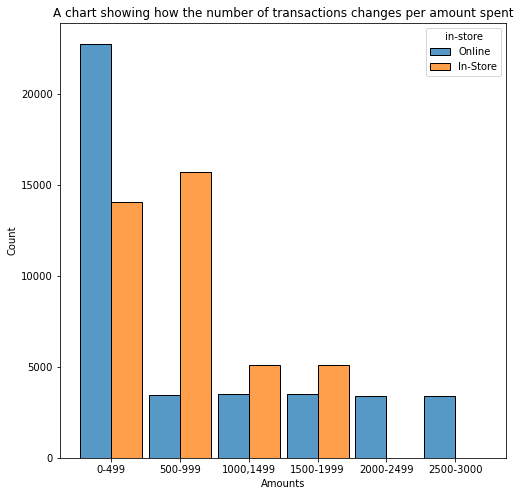

In [37]:
#Creating an Amounts column to convert amount into categorical data
data_amounts = data.copy()
data_amounts['Amounts'] = pd.cut(x = data['amount'], bins = [0,500,1000,1500,2000,2500,3001], labels = ['0-499','500-999', '1000,1499', '1500-1999', '2000-2499', '2500-3000'])

#Cleaning data to show online/in-store and the region name
data_amounts = data_amounts.replace({'in-store': online_dict,
                                         'region': region_dict})

plt.figure(figsize=(8,8))
sns.histplot(shrink= .9, x="Amounts", hue="in-store", data=data_amounts, stat="count", multiple="dodge")
plt.title('A chart showing how the number of transactions changes per amount spent')

We can see most transactions with amounts £0-500 are made online, whereas transactions £500-999 are mostly made in-store. All other amounts are fairly evenly distributed up to £2500-3000 where all (a small number) of transactions are made online.

### Conclusion

North: 
- Expected age distribution. 
- Only purchase in store with average spend per item of ~ £160.  
- 17.8% of total revenue.

<br>

South: 
- Oldest population of the regions.
- Only purchase online with average spend of ~£55 per item.
- 7.5% of total revenue

<br>

East:
- Second oldest population, but with an expected age distribution.
- Purchase more in-store than online, second most expensive region at ~£210 per item.
- 24.7% of total revenue

<br>

West:
- Youngest population
- Purchase equally in-store and online, most expensive region at ~ £270 per item
- 49.9% of revenue (most of all)

<br>

Other findings:
- All regions have a same mean number of items per transaction, but the amounts vary a lot. Could be completley different items being sold or at very different prices.
- Online and in-store prices also varies vastly, with the average price for an item online in the South ~ £50 but closer to ~ £350 in the East and West.
- Gen X, Millenials and Gen X all purchase more in-store than online, Baby Boomers & Silent Generation purchase more online
- Transactions between £0-500 are mostly done online, and £500-1000 mostly done in store.

## Can we predict the region of a customer based on their demographics?

We will start by defining metrics to evaluate our models.

<br>

Precision:
- How many instances classified as positive actually were? I.e The ratio of True Positives to the sum of True Positives and False Positives TP/(TP+FP)
<br>

Recall:
- For all instances that were actually positive, how many were classified correctly? I.e The ratio of True positives to the sum of True Positives and False Negatives TP/(TP+FN)
<br>

F1-score:
- The harmonic mean of Precision and Recall, a representation of both scores.
<br>

Support:
- The number of instances of each class used.

In [38]:
#Creating classifier algos for cross validation
algos_Class = []
algos_Class.append(('Random Forest Classifier',RandomForestClassifier()))
algos_Class.append(('Decision Tree Classifier', DecisionTreeClassifier()))
algos_Class.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
algos_Class.append(('K Nearest Neighbour Classifier', KNeighborsClassifier())) 
#algos_Class.append(('X Gradient Boosting Classifier', XGBClassifier()))

#Cross validation for predicting Generation in region 1
indep_vars = data.drop(columns = ['region','Generation'])
dep_var = data['region']

results_region = []
names_region = []
print('Cross validation score for accuracy on predicting region')
for name, model in algos_Class:
    result = cross_val_score(model, indep_vars, dep_var, cv=3,scoring = 'accuracy')
    names_region.append(name)
    results_region.append(result)
#print cross val scores
for i in range(len(names_region)):
    print(names_region[i],results_region[i].mean())


Cross validation score for accuracy on predicting region
Random Forest Classifier 0.5849159849885951
Decision Tree Classifier 0.5620600135779846
Gradient Boosting Classifier 0.643281380474906
K Nearest Neighbour Classifier 0.5044199475916468


In [39]:
#Train/Test Split
indep_vars_train, indep_vars_test, dep_var_train, dep_var_test = train_test_split(indep_vars, dep_var, test_size = .30, random_state = 123)

#Modeling (Classification) of
algo_region = GradientBoostingClassifier()  
model_region = algo_region.fit(indep_vars_train,dep_var_train)

#Predictions
preds_region = model_region.predict(indep_vars_test)
#Save the accuracy
region_accuracy= classification_report(dep_var_test, preds_region)
#Print accuracy
print(region_accuracy)

              precision    recall  f1-score   support

           1       0.40      0.52      0.45      4838
           2       0.90      1.00      0.95      5979
           3       0.53      0.23      0.32      5391
           4       0.65      0.73      0.69      7786

    accuracy                           0.64     23994
   macro avg       0.62      0.62      0.60     23994
weighted avg       0.63      0.64      0.62     23994



<AxesSubplot:>

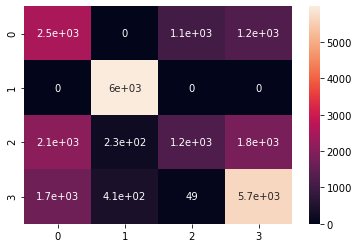

In [41]:
reg_conf_matrix = confusion_matrix(dep_var_test, preds_region)
sns.heatmap(reg_conf_matrix,annot=True)

Our model is very good at predicting region 2, with a precision of ~90%, but relatviely low scores for regions 1 and 3.

We can see in the below the importance of our features. As discovered in the EDA, 'items' had no variation between the regions and this is shown by the almost 0 importance.

Text(0, 0.5, 'Feature Importance Score')

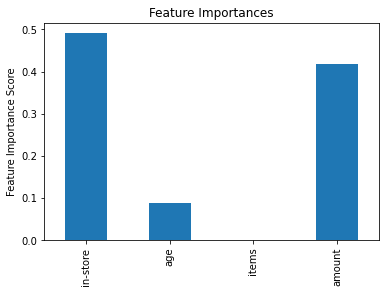

In [42]:
#Plotting the feature importance of our model
feat_importance=pd.Series(algo_region.feature_importances_,indep_vars_train.columns)
feat_importance.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

## Can we predict the generation of a customer in a region based on other demographic data?

### Region 1 (North)

In [44]:
#Cross validation for predicting Generation in region 1
X1 = region_1_data.drop(columns = ['age','Generation'])
y1 = region_1_data['Generation']

results = []
names = []
print('Cross validation score for accuracy on predicting age in the North (1)')
for name, model in algos_Class:
    result = cross_val_score(model, X1, y1, cv=3,scoring = 'accuracy')
    names.append(name)
    results.append(result)
#print cross val scores
for i in range(len(names)):
    print(names[i],results[i].mean())

Cross validation score for accuracy on predicting age in the North (1)
Random Forest Classifier 0.30749578684751816
Decision Tree Classifier 0.3064330094336823
Gradient Boosting Classifier 0.3699443869968055
K Nearest Neighbour Classifier 0.3114956617459259


In [45]:
#Train/Test Split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = .30, random_state = 123)

#Modeling (Classification) of
algo = GradientBoostingClassifier()  
model = algo.fit(X1_train,y1_train)

#Predictions
preds = model.predict(X1_test)

#Save the accuracy
x1_accuracy= classification_report(y1_test, preds)
#Print accuracy
print(x1_accuracy)

              precision    recall  f1-score   support

 Baby Boomer       0.35      0.02      0.04       786
       Gen X       0.32      0.18      0.23      1628
       Gen Z       0.04      0.00      0.00       565
  Millennial       0.38      0.78      0.51      1821

    accuracy                           0.36      4800
   macro avg       0.27      0.25      0.20      4800
weighted avg       0.31      0.36      0.28      4800



The above table shows the classification report, this tells us how accurately we can predict a customers age from the other data we have. We can see varying rates of precision for the different generations but an accuracy rate of 37% across all generations. We can conclude that in region 1 we are unlikely to be able to correctly predict the generation of a customer through their transaction data.

### Region 2 (South)

In [46]:
#Cross validation for predicting Generation in region 2
X2 = region_2_data.drop(columns = ['age','Generation'])
y2= region_2_data['Generation']

results_2 = []
names_2 = []
print('Cross validation score for accuracy on predicting Generation in the South (2)')
for name, model in algos_Class:
    result = cross_val_score(model, X2, y2, cv=3,scoring = 'accuracy')
    names_2.append(name)
    results_2.append(result)
#print cross val scores
for i in range(len(names_2)):
    print(names_2[i],results_2[i].mean())

Cross validation score for accuracy on predicting Generation in the South (2)
Random Forest Classifier 0.27683317888295605
Decision Tree Classifier 0.272982111073987
Gradient Boosting Classifier 0.3239471257370165
K Nearest Neighbour Classifier 0.3021905611456886


In [50]:
#Train/Test Split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = .30, random_state = 123)

#Modeling (Classification) of
algo_2 = GradientBoostingClassifier()  
model_2 = algo_2.fit(X2_train,y2_train)

#Predictions
preds_2 = model_2.predict(X2_test)

X2_accuracy= classification_report(y2_test, preds_2)
#Print accuracy
print(X2_accuracy)

                       precision    recall  f1-score   support

          Baby Boomer       0.33      0.90      0.48      1967
                Gen X       0.26      0.06      0.10      1710
           Millennial       0.24      0.03      0.05      1476
The Silent Generation       0.17      0.00      0.01       846

             accuracy                           0.32      5999
            macro avg       0.25      0.25      0.16      5999
         weighted avg       0.27      0.32      0.20      5999



Region 2 has a lower accuracy rate than Region 1 at 32%, meaning we are less likely to be able to predict the age generation of region 2 than region 1. Baby Boomers we have a 47% chance of predicting and the Silent Generation a very low score indeed, suprising given the only Silent Generation demographic from our data is in Region 2.

### Region 3 (East)

In [51]:
#Cross validation for predicting Generation in region 3
X3 = region_3_data.drop(columns = ['age','Generation'])
y3= region_3_data['Generation']

results_3 = []
names_3 = []
print('Cross validation score for accuracy on predicting Generation in the East (3)')

for name, model in algos_Class:
    result = cross_val_score(model, X3, y3, cv=3,scoring = 'accuracy')
    names_3.append(name)
    results_3.append(result)
#print cross val scores
for i in range(len(names_3)):
    print(names_3[i],results_3[i].mean())


Cross validation score for accuracy on predicting Generation in the East (3)
Random Forest Classifier 0.3069444444444444
Decision Tree Classifier 0.3068333333333333
Gradient Boosting Classifier 0.3377222222222222
K Nearest Neighbour Classifier 0.31016666666666665


In [52]:
#Train/Test Split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = .30, random_state = 123)

#Modeling (Classification) of
algo_3 = GradientBoostingClassifier()  
model_3 = algo_3.fit(X3_train,y3_train)

#Predictions
preds_3 = model.predict(X3_test)

x3_accuracy= classification_report(y3_test, preds_3)
#Print accuracy
print(x3_accuracy)

NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Similarly low accuracy rate in Region 3, with an accuracy rate of 34%. Gen X has a higher predictive rate than all other generations at 44%, which is still very low.

### Region 4 (West)

In [ ]:
#Cross validation for predicting Generation in region 4
X4 = region_4_data.drop(columns = ['age','Generation'])
y4= region_4_data['Generation']

results_4 = []
names_4 = []
print('Cross validation score for accuracy on predicting Generation in the West (4)')

for name, model in algos_Class:
    result = cross_val_score(model, X4, y4, cv=3,scoring = 'accuracy')
    names_4.append(name)
    results_4.append(result)
#print cross val scores
for i in range(len(names_4)):
    print(names_4[i],results_4[i].mean())

In [ ]:
#Train/Test Split
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = .30, random_state = 123)

#Modeling (Classification) of
algo_4 = GradientBoostingClassifier()  
model_4 = algo_4.fit(X4_train,y4_train)

#Predictions
preds_4 = model.predict(X4_test)

x4_accuracy= classification_report(y4_test, preds_4)
#Print accuracy
print(x4_accuracy)

We see an accuracy rate of 41% in Region 4, the highest of all Regions, which is still very low. Millennials here are the most likely to be predicted at 55%.

<br>

To conclude, it is very unlikely that we can accurately predict the age of a customer in a region based on the other transactional data we have.  Our models can predict with a accuracy between 32% and 41%, which is a little better than guessing at 25%.

## Conclusion

- Gradient Boosting CLassification has varying accuracy predicting the region of a customer, with very high accuracy in the South ~100%, to low in the North ~40%. However, 40% is still better than a random guess.

<br>

- The classification models we have tested have not been able accurately predict the generation of a customer based on their other transactional data, with an accuracy rate between 32% and 41% for the four regions. 